<a href="https://colab.research.google.com/github/ric4234/AI-Fridays/blob/main/Analisi%20Di%20Immagini/02_Image_Segmentation.ipynb" target="_parent\"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Segmentation

In this exercise, we are going to perform image segmentation and visual prompting. By that, we will specify a point of a picture and the segmented model will identify the object of interest



#### 1 - Install dependencies and create utils functions

In [5]:
!pip install transformers
!pip install gradio
!pip install timm
!pip install torchvision

The following code contains few utils function that will be used in the nexts sections

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def load_image_from_url(url):
    return Image.open(requests.get(url, stream=True).raw)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3),
                                np.array([0.6])],
                               axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0),
                               w,
                               h, edgecolor='green',
                               facecolor=(0,0,0,0),
                               lw=2))

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image,
                                   boxes,
                                   input_points,
                                   input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points_and_boxes_on_image(raw_image,
                                   boxes,
                                   input_points,
                                   input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0],
               pos_points[:, 1],
               color='green',
               marker='*',
               s=marker_size,
               edgecolor='white',
               linewidth=1.25)
    ax.scatter(neg_points[:, 0],
               neg_points[:, 1],
               color='red',
               marker='*',
               s=marker_size,
               edgecolor='white',
               linewidth=1.25)


def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img


def show_mask_on_image(raw_image, mask, return_image=False):
    if not isinstance(mask, torch.Tensor):
      mask = torch.Tensor(mask)

    if len(mask.shape) == 4:
      mask = mask.squeeze()

    fig, axes = plt.subplots(1, 1, figsize=(15, 15))

    mask = mask.cpu().detach()
    axes.imshow(np.array(raw_image))
    show_mask(mask, axes)
    axes.axis("off")
    plt.show()

    if return_image:
      fig = plt.gcf()
      return fig2img(fig)




def show_pipe_masks_on_image(raw_image, outputs):
  plt.imshow(np.array(raw_image))
  ax = plt.gca()
  for mask in outputs["masks"]:
      show_mask(mask, ax=ax, random_color=True)
  plt.axis("off")
  plt.show()

#### 2 - Mask generation with SAM


Mask generation is the task of generating masks that identify a specific object or region of interest in a given image. Masks are used in segmentation tasks to isolate the object of interest for further processing or analysis.

In this exercise, we will do the Mask Generation task with the Segment Anything Moodel (SAM), which was released by Meta AI.
The SAM consists of the following components: An Image Encoder, a Decoder, and a Mask Decoder.


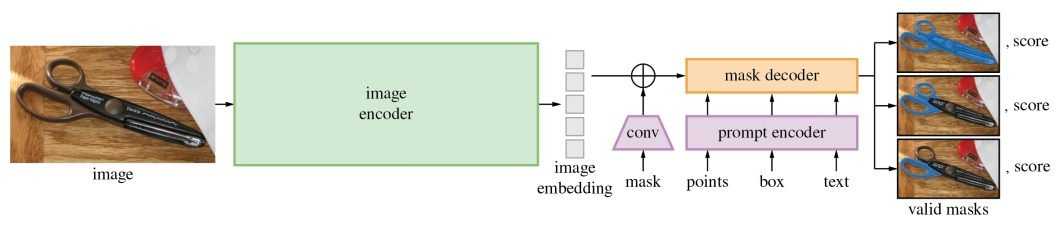



*   Image Encoder: component responsible for processing and transforming input images into a comprehensive set of features. Using a transformer-based approach, this encoder compresses images into a dense feature matrix. This matrix forms the foundational understanding from which the model identifies various image elements.  
*   Prompt Encoder: interprets various forms of input prompts, be they text-based, points, rough masks, or a combination thereof. This encoder translates these prompts into an embedding that guides the segmentation process. This enables the model to focus on specific areas or objects within an image as the input dictates.  
*   Mask Decoder: this component is responsible for the final output, determining the precise contours and areas of each segment within the image

How these components interact with each other is equally vital for effective image segmentation as their capabilities: The image encoder first creates a detailed understanding of the entire image, breaking it down into features that the engine can analyze. The prompt encoder then adds context, focusing the model’s attention based on the provided input, whether a simple point or a complex text description. Finally, the mask decoder uses this combined information to segment the image accurately, ensuring that the output aligns with the input prompt’s intent.

More specifically, we fill fo this task with SlimSAM-uniform-77 model (https://huggingface.co/Zigeng/SlimSAM-uniform-77). SlimSAM does the same task as SAM, but it is smaller and usable on a small hardware

You can find more about mask generation on this Huggingface section: https://huggingface.co/tasks/mask-generation and the exaplanation of the architecture on https://viso.ai/deep-learning/segment-anything-model-sam-explained/

In [3]:
from transformers import pipeline
sam_pipe = pipeline("mask-generation",
    "Zigeng/SlimSAM-uniform-77") # Load the model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/38.9M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

Then, we import an image from url

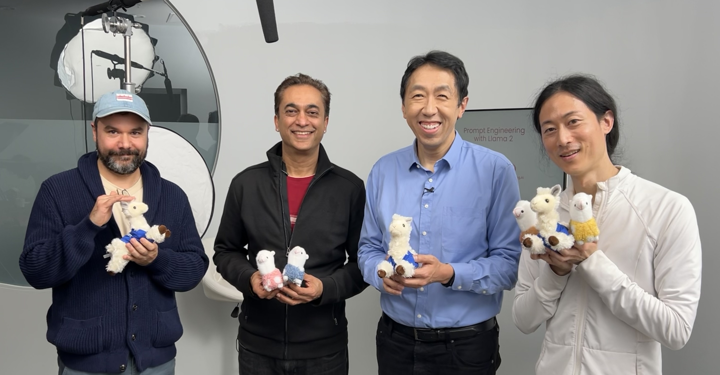

In [5]:
from PIL import Image
import requests
from io import BytesIO

# Fetch image from URL
url = 'https://github.com/ric4234/AI-Fridays/blob/main/Analisi%20Di%20Immagini/Images/meta_llamas.jpg?raw=true'  # Replace with your image URL

raw_image = load_image_from_url(url)

raw_image.resize((720, 375))

Then, we pass the image to the pipeline to perform the Mask Generation task. points per batch is a key variable: the higher the value of 'points_per_batch', the more efficient pipeline inference will be, but the execution will take more time.

Execute the following code only if you have a lot of time 😀

In [ ]:
output = sam_pipe(raw_image, points_per_batch=64)

In [ ]:
show_pipe_masks_on_image(raw_image, output)

As you can see from the result, each object has been correctly segmented. The problem of this approach is that you need to iterate over all the points and process the generated mask, which can be slow for many applications

#### 3 - Faster Inference with SAM: Infer an Image and a Single Point

In this specific use case we are going to infer a single point in an image


In [1]:
from transformers import SamModel, SamProcessor

model = SamModel.from_pretrained(
    "Zigeng/SlimSAM-uniform-77")

processor = SamProcessor.from_pretrained(
    "Zigeng/SlimSAM-uniform-77")

model # Print the architecture

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 168, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((168,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=168, out_features=504, bias=True)
          (proj): Linear(in_features=168, out_features=168, bias=True)
        )
        (layer_norm2): LayerNorm((168,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=168, out_features=696, bias=True)
          (lin2): Linear(in_features=696, out_features=168, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(168, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
      (c

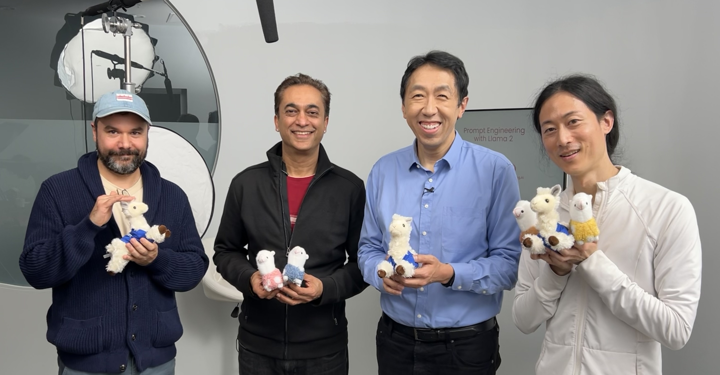

In [9]:
from PIL import Image
import requests
from io import BytesIO

# Fetch image from URL
url = 'https://github.com/ric4234/AI-Fridays/blob/main/Analisi%20Di%20Immagini/Images/meta_llamas.jpg?raw=true'  # Replace with your image URL

raw_image = load_image_from_url(url)

raw_image.resize((720, 375))


From the selected image, we identify a point that we want to infer. For this example, we pick a point in the blue shirt. The following code help us to find a point in the correct region

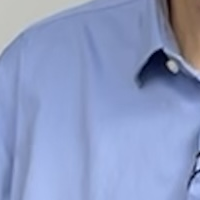

In [15]:
# Convert the raw image to a NumPy array
image_array = np.array(raw_image)

# Define the coordinates and size of the square to filter
x = 1500  # x-coordinate of the top-left corner of the square
y = 600  # y-coordinate of the top-left corner of the square
size = 200  # Size of the square (e.g., 20x20 pixels)

# Filter the square
filtered_square = image_array[y:y+size, x:x+size]

# Convert the filtered square back to an image
filtered_image = Image.fromarray(filtered_square)

# Save or display the filtered image
filtered_image.show()

filtered_image

In [16]:
input_points = [[[1600, 700]]] # We pick a point inside the blue shirt

inputs = processor(raw_image,
                 input_points=input_points,
                 return_tensors="pt") # Return PyTorch tensors

In [17]:
import torch

with torch.no_grad(): # we don't compute the gradient
    outputs = model(**inputs)

Once we have retrieved the output from the model we need to post process the precidted masks in order to resize them to the size of the original image. We can call post_process_masks in order to get all the predicted masks

In [ ]:
predicted_masks = processor.image_processor.post_process_masks(
    outputs.pred_masks,
    inputs["original_sizes"],
    inputs["reshaped_input_sizes"]
)

print(len(predicted_masks)) # 1 , which is the number of images

predicted_mask = predicted_masks[0] # Let's consider the first mask and the inspect its shape
predicted_mask.shape

torch.Size([1, 3, 1500, 2880])

From the predicted_mask shape we can see that we have a tensor of size 1, which is the batch size, 3, and then the size of the image. The number 3 derives from the fact that the model predicts 3 segmentation masks toghether with their confidence scores.
In the following code, we inspect the outputs scores of the predictions

In [18]:
outputs.iou_scores # As you can see, the first mask seems to be the mask with higher confidence

tensor([[[0.9583, 0.9551, 0.9580]]])

Then we print all the predicted segmentations.
From this result, in two cases over 3 the model was able to segment the shirt, while in the first one it segmented the person entirely

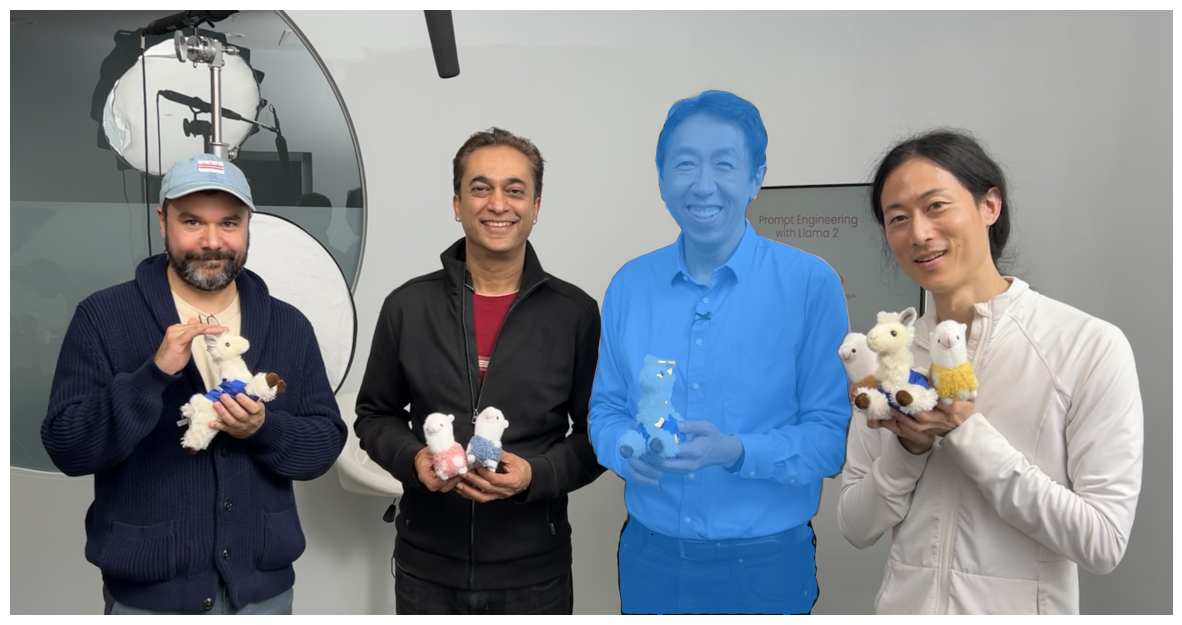

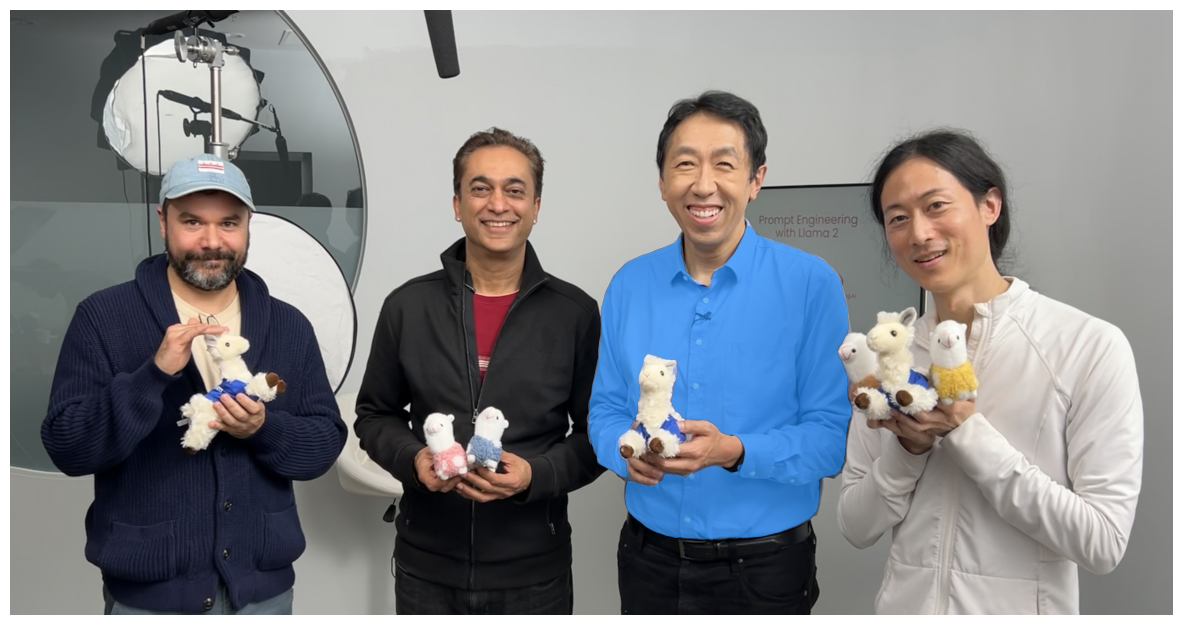

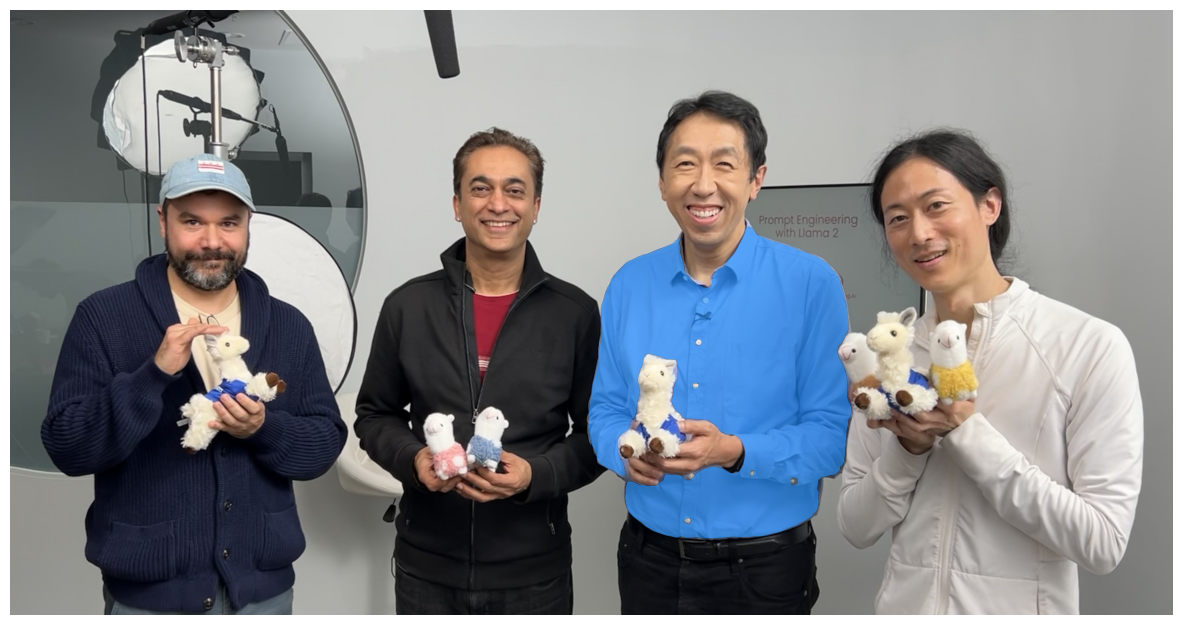

In [ ]:
for i in range(3):
    show_mask_on_image(raw_image, predicted_mask[:, i])

#### 4 - Depth Estimation with DPT

In [ ]:
depth_estimator = pipeline(task="depth-estimation",
                        model="Intel/dpt-hybrid-midas")

config.json:   0%|          | 0.00/9.88k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/490M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


preprocessor_config.json:   0%|          | 0.00/382 [00:00<?, ?B/s]

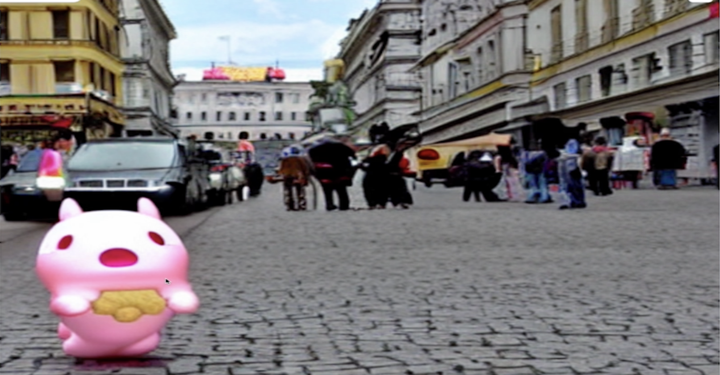

In [ ]:
from PIL import Image
import io
from io import BytesIO
import requests
# Fetch image from URL
url = 'https://github.com/ric4234/AI-Fridays/blob/main/Analisi%20Di%20Immagini/Images/gradio_tamagochi_vienna.png?raw=true'  # Replace with your image URL
response = requests.get(url)
raw_image = Image.open(BytesIO(response.content))
raw_image.resize((720, 375))

In [ ]:
output = depth_estimator(raw_image)
output

{'predicted_depth': tensor([[[ 248.4070,  252.1829,  256.9170,  ...,  595.8293,  591.8105,
            471.2294],
          [ 247.3371,  254.8536,  257.9680,  ...,  596.0250,  589.0449,
            594.1439],
          [ 259.7673,  259.5480,  261.4166,  ...,  597.6287,  595.3369,
            595.7491],
          ...,
          [3014.1091, 3018.4861, 3019.1719,  ..., 3275.2781, 3269.3459,
           3268.8369],
          [3041.5544, 3040.2783, 3044.4644,  ..., 3280.7483, 3289.3672,
           3274.8713],
          [3039.7495, 3056.0349, 3052.9734,  ..., 3302.0000, 3298.1899,
           3286.9138]]]),
 'depth': <PIL.Image.Image image mode=L size=1612x1242>}

In [ ]:
output["predicted_depth"].shape

torch.Size([1, 384, 384])

In [ ]:
output["predicted_depth"].unsqueeze(1).shape

torch.Size([1, 1, 384, 384])

In [ ]:
prediction = torch.nn.functional.interpolate(
    output["predicted_depth"].unsqueeze(1),
    size=raw_image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

In [ ]:
prediction.shape

torch.Size([1, 1, 1242, 1612])

In [ ]:
raw_image.size[::-1],

((1242, 1612),)

In [ ]:
prediction

tensor([[[[ 248.1577,  248.2614,  248.7576,  ...,  468.0626,  447.0033,
            442.8550],
          [ 248.0309,  248.1445,  248.6918,  ...,  477.7612,  458.3926,
            454.5767],
          [ 247.0835,  247.2386,  247.9993,  ...,  508.8531,  494.9497,
            492.2079],
          ...,
          [3040.0393, 3040.3989, 3042.2324,  ..., 3285.1289, 3283.1475,
           3282.7578],
          [3037.8716, 3038.3877, 3041.0291,  ..., 3288.0652, 3286.3364,
           3285.9917],
          [3037.5520, 3038.1143, 3040.9961,  ..., 3289.0701, 3287.3911,
           3287.0552]]]])

In [ ]:
import numpy as np

In [ ]:
output = prediction.squeeze().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

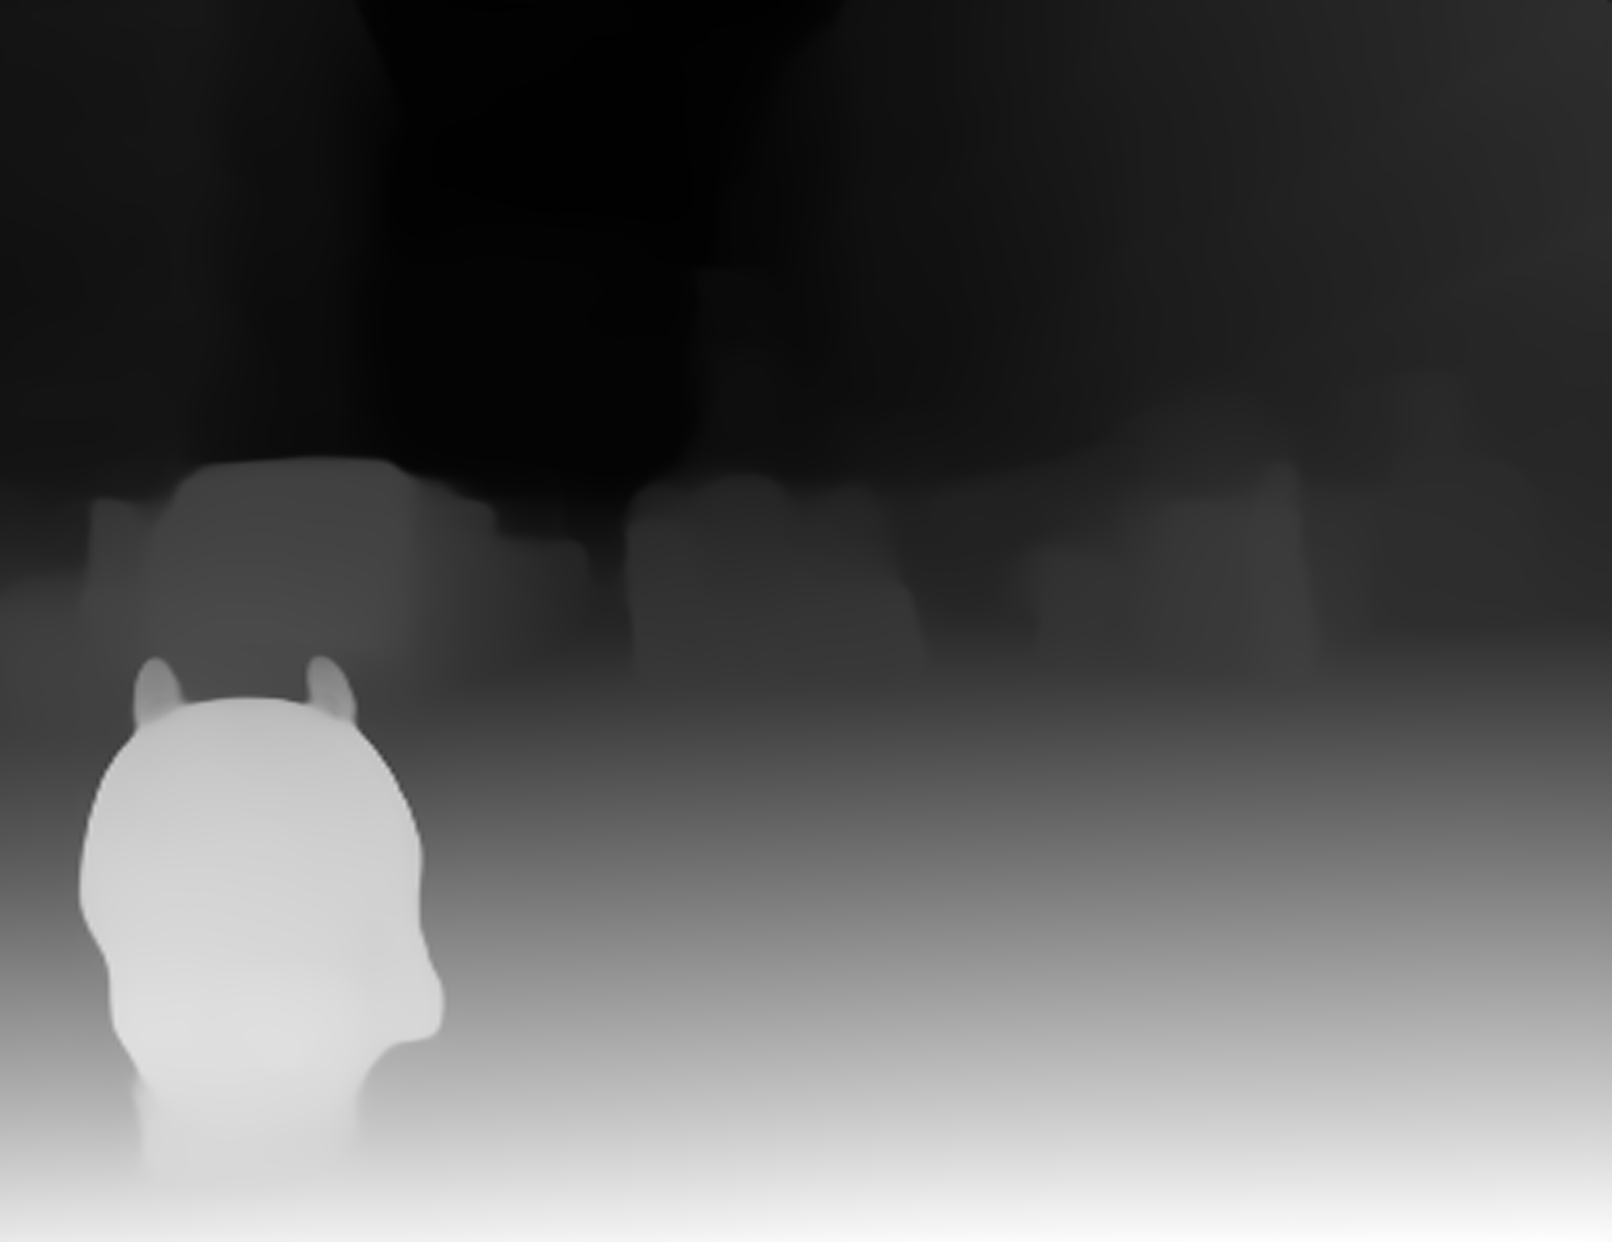

In [ ]:
depth

In [ ]:
import os
import gradio as gr
from transformers import pipeline

In [ ]:
def launch(input_image):
    out = depth_estimator(input_image)

    # resize the prediction
    prediction = torch.nn.functional.interpolate(
        out["predicted_depth"].unsqueeze(1),
        size=input_image.size[::-1],
        mode="bicubic",
        align_corners=False,
    )

    # normalize the prediction
    output = prediction.squeeze().numpy()
    formatted = (output * 255 / np.max(output)).astype("uint8")
    depth = Image.fromarray(formatted)
    return depth

In [ ]:
iface = gr.Interface(launch,
                     inputs=gr.Image(type='pil'),
                     outputs=gr.Image(type='pil'))

In [ ]:
iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://8efd59e3c7c2c6f747.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
iface.close()

Closing server running on port: 7860
